# Avaliar o efeito do "abrasileiramento" dos preços dos derivados de petróleo. 

Empregar o módulo `causalimpact` neste problema

O atual governo (3º mandato do Lula) ter anunciado o "abrasileiramento" dos preços ao adotar uma redução dos preços dos combustíveis, abre a oportunidade de realizar inferência causal dessa suposta política, a fim de avaliar a persistência dos efeitos dessa nova política sobre o preço do diesel e da gasolina.

A oportunidade é percebida pelo fato da Petrobrás (maior _player_ na área de refino) estar abandonando de forma decisiva a política de PPI (Paridade de Preços de Importação), a qual preconiza que os preços dos combustíveis seguirão a cotação internacional dos insumos (petróleo). Dessa forma, consegue-se imaginar [uma intervenção/tratamento que está desvinculada do preço da matéria-prima](https://agenciabrasil.ebc.com.br/economia/noticia/2023-05/petrobras-anuncia-nova-politica-de-precos-de-combustiveis), o que facilita para inserir uma variável de controle que não esteja ligada à intervenção/tratamento em si. 

As condições citadas atendem as premissas de inferência causal através do modelo de _Bayesian Structural Time Series_ construído pelo módulo [causalimpact](https://pypi.org/project/pycausalimpact/): 

> The model makes as assumption (which is recommended to be confirmed in your data) that the response variable can be precisely modeled by a linear regression with what is known as "covariates" (or X) that __must not be affected by the intervention that took place.__

Logo, o `X` será a cotação do petróleo, a qual não será afetada pela citada intervenção. [Este notebook](https://nbviewer.org/github/jamalsenouci/causalimpact/blob/master/GettingStarted.ipynb) consegue fornecer detalhes de como aplicar o módulo, principalmente quando se pretende em ir em tópicos mais avançados. 

## Carregar módulos necessários para o estudo

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from statsmodels.tsa.arima_process import ArmaProcess
from causalimpact import CausalImpact

print(pd)
print(np)
print(plt)
print(sns)
print(date)
print(ArmaProcess)
print(CausalImpact)

<module 'pandas' from '/home/chico_linux/.local/lib/python3.10/site-packages/pandas/__init__.py'>
<module 'numpy' from '/home/chico_linux/.local/lib/python3.10/site-packages/numpy/__init__.py'>
<module 'matplotlib.pyplot' from '/home/chico_linux/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>
<module 'seaborn' from '/home/chico_linux/.local/lib/python3.10/site-packages/seaborn/__init__.py'>
<class 'datetime.date'>
<class 'statsmodels.tsa.arima_process.ArmaProcess'>
<class 'causalimpact.main.CausalImpact'>


## Carregar as bases de dados necessárias

A base de dados do preço do combustível nas refinarias e importadoras, extraído desse site [aqui](https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-de-produtores-e-importadores-de-derivados-de-petroleo). Há outra [base](https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/serie-historica-do-levantamento-de-precos), relacionada a dados de de postos de gasolina (final da cadeia), mas não é relevante usar no experimento. 

In [2]:
plant = pd.read_excel("https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/ppidp/precos-medios-ponderados-semanais-2013.xls",
                      engine="xlrd",
                      skiprows=8,
                      skipfooter=8,
                      usecols="A:I",
                      na_values="***",
                      names=["product", "from_", "until", "north", "northeast", "midwest", "south", "southeast", "brazil"])

plant

,product,from_,until,north,northeast,midwest,south,southeast,brazil
0,Asfalto Diluído de Petróleo de Cura Média 30 (...,2012-12-31,2013-01-06,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
1,Asfalto Diluído de Petróleo de Cura Média 30 (...,2013-01-07,2013-01-13,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
2,Asfalto Diluído de Petróleo de Cura Média 30 (...,2013-01-14,2013-01-20,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
3,Asfalto Diluído de Petróleo de Cura Média 30 (...,2013-01-21,2013-01-27,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
4,Asfalto Diluído de Petróleo de Cura Média 30 (...,2013-01-28,2013-02-03,1.29360,1.29360,NaN,1.29360,1.29360,1.29360
...,...,...,...,...,...,...,...,...,...
8902,Querosene de Aviação - QAV (R$/litro),2023-07-03,2023-07-09,3.43668,3.34133,NaN,3.47815,3.46374,3.44711
8903,Querosene de Aviação - QAV (R$/litro),2023-07-10,2023-07-16,3.42461,3.26774,NaN,3.45461,3.45236,3.44563
8904,Querosene de Aviação - QAV (R$/litro),2023-07-17,2023-07-23,3.54543,3.37457,NaN,3.48249,3.40205,3.40921
8905,Querosene de Aviação - QAV (R$/litro),2023-07-24,2023-07-30,3.83527,3.32598,NaN,3.47986,3.40239,3.40927


Tudo certo para usar! =D

Agora baixe os dados de preços de petróleo do tipo WTI, do tipo leve e pouco sulfuroso (`Cushing, OK WTI Spot Price FOB (Dollars per Barrel)`). Dessa cotação que podemos extrair uma variável de controle, pois a Petrobrás compra combustível do tipo leve para refinar e produzir combustível como gasolina e diesel.

In [3]:
oil = pd.read_excel("https://www.eia.gov/dnav/pet/hist_xls/RWTCd.xls", 
                    sheet_name="Data 1",
                    skiprows=2,
                    names=["day", "wti_price"])

oil

,day,wti_price
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87
...,...,...
9467,2023-08-01,81.37
9468,2023-08-02,79.50
9469,2023-08-03,81.56
9470,2023-08-04,82.76


## Faça o EDA para entender melhor sobre os dados extraídos

In [4]:
plant["product"].drop_duplicates()

0       Asfalto Diluído de Petróleo de Cura Média 30 (...
553     Asfalto Diluído de Petróleo de Cura Rápida 250...
709                            Biodiesel B-100 (R$/litro)
792           Cimento Asfáltico de Petróleo 30 45 (R$/kg)
1345          Cimento Asfáltico de Petróleo 50 70 (R$/kg)
1898             Gás Liquefeito de Petróleo - GLP (R$/kg)
3199                          Gasolina A Comum (R$/litro)
3752                        Gasolina A Premium (R$/litro)
4008                           Nafta Petroquímica (R$/kg)
4060                           Nafta Petroquímica (R$/Kg)
4561                          Óleo Combustível A1 (R$/kg)
5114                          Óleo Combustível A2 (R$/kg)
5219                          Óleo Combustível B1 (R$/kg)
5675                          Óleo Combustível B2 (R$/kg)
5952              Óleo Diesel Marítimo DMA-MGO (R$/litro)
6505                Óleo Diesel Não Rodoviário (R$/litro)
6645                          Óleo Diesel S-10 (R$/litro)
7198          

As distribuidoras de combustível compram nas refinarias a gasolina tipo “A”. Atendendo à legislação brasileira, a gasolina vendida nos postos deve ser misturada com Etanol Anidro. Desta maneira, no preço que o consumidor paga está incluído o preço de realização da Petrobras, o custo do etanol (que é definido livremente pelos seus produtores) e os custos e as margens de comercialização das distribuidoras e dos postos revendedores, bem como todos os impostos devidos.

Filtre por `Gasolina A Comum`. 

As distribuidoras de combustível compram nas refinarias o diesel tipo “A”, que é o óleo diesel S-10 com teor máximo de enxofre de 10mg/kg (ppm = partes por milhão): desenvolvido para motores a diesel emitirem menores teores de material particulado e NOx do que os da geração anterior.

Atendendo à legislação brasileira, o diesel automotivo vendido no Brasil deve ser misturado com biodiesel, um combustível renovável produzido a partir de óleos vegetais ou gorduras animais, formando o óleo diesel “B”, que é revendido nos postos. No preço que o consumidor paga no posto, portanto, além dos impostos e da parcela Petrobras, estão incluídos também o custo de aquisição do biodiesel e os custos e margens de comercialização das distribuidoras e dos revendedores.

Filtre também pelo `Óleo Diesel S-10`

In [5]:
plant_sel = plant[plant["product"].isin(["Gasolina A Comum (R$/litro)", "Óleo Diesel S-10 (R$/litro)"])].\
    copy().\
    drop(columns=["north", "northeast", "midwest", "south", "southeast"]).\
    rename(columns={"brazil": "price"}) # Vamos usar o preço do Brasil
plant_sel = plant_sel[plant_sel.from_ >= "2022-01-01"]

plant_sel

,product,from_,until,price
3669,Gasolina A Comum (R$/litro),2022-01-03,2022-01-09,4.10261
3670,Gasolina A Comum (R$/litro),2022-01-10,2022-01-16,4.17026
3671,Gasolina A Comum (R$/litro),2022-01-17,2022-01-23,4.19075
3672,Gasolina A Comum (R$/litro),2022-01-24,2022-01-30,4.21726
3673,Gasolina A Comum (R$/litro),2022-01-31,2022-02-06,4.23894
...,...,...,...,...
7193,Óleo Diesel S-10 (R$/litro),2023-07-03,2023-07-09,3.08891
7194,Óleo Diesel S-10 (R$/litro),2023-07-10,2023-07-16,3.10523
7195,Óleo Diesel S-10 (R$/litro),2023-07-17,2023-07-23,3.08251
7196,Óleo Diesel S-10 (R$/litro),2023-07-24,2023-07-30,3.10315


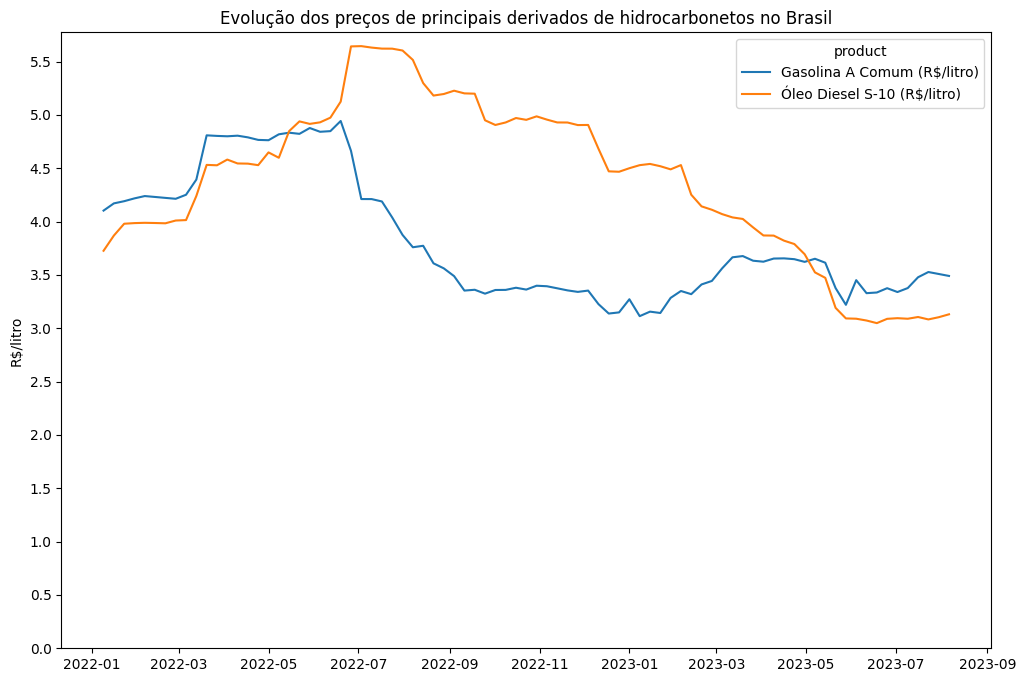

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    x="until", 
    y="price",
    hue="product",
    data=plant_sel
)

plt.xlabel("", size=10)
plt.ylabel("R$/litro", size=10)

ax.set_title("Evolução dos preços de principais derivados de hidrocarbonetos no Brasil")
ax.set_yticks(np.arange(0, 6 , 0.5))

Apesar de ambos serem derivados do petróleo, esses produtos possuem trajetórias de preço muito distintas. 

Veja a evolução dos preço do barril de petróleo WTI

Text(0.5, 1.0, 'Evolução do preço de barril de petróleo - WTI')

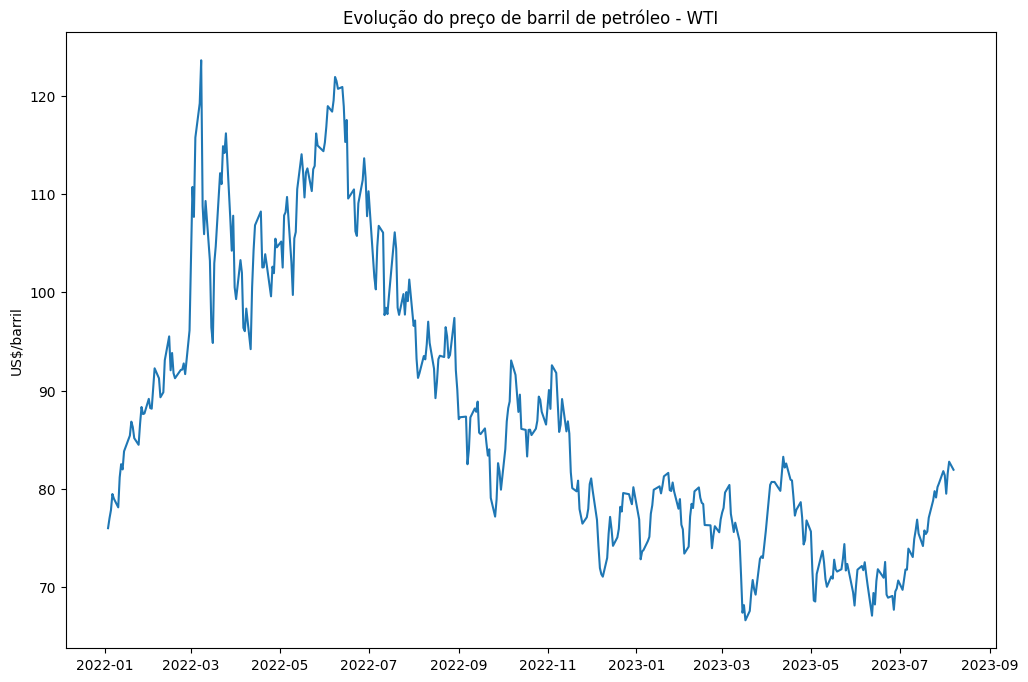

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    x="day", 
    y="wti_price",
    data=oil[oil.day >= "2022-01-01"]
)

plt.xlabel("", size=10)
plt.ylabel("US$/barril", size=10)

ax.set_title("Evolução do preço de barril de petróleo - WTI")

Veja graficamente o preço da gasolina e diesel em relação ao do barril de petróleo. Só que isso está numa periodicidade diferente da outra base, a fim de fazermos uma comparação, logo deixe as bases em termos temporais semelhantes. 

Faça a base de petróleo ter uma média, com base no período de pesquisa da base de combustíveis do Brasil.

In [8]:
oil_avg = plant_sel[["from_", "until"]].drop_duplicates().copy()

oil_avg = oil_avg.merge(oil[oil.day >= "2022-01-01"], how="cross")

oil_avg = oil_avg[oil_avg.day.between(oil_avg.from_, oil_avg.until)].groupby(["from_", "until"], as_index=False).agg({"wti_price": "mean"})

,from_,until,wti_price
0,2022-01-03,2022-01-09,77.8580
1,2022-01-10,2022-01-16,81.5160
2,2022-01-17,2022-01-23,85.9275
3,2022-01-24,2022-01-30,86.9400
4,2022-01-31,2022-02-06,89.5960
...,...,...,...
78,2023-07-03,2023-07-09,71.7900
79,2023-07-10,2023-07-16,75.1980
80,2023-07-17,2023-07-23,75.6080
81,2023-07-24,2023-07-30,79.6800


Agora faça o gráfico

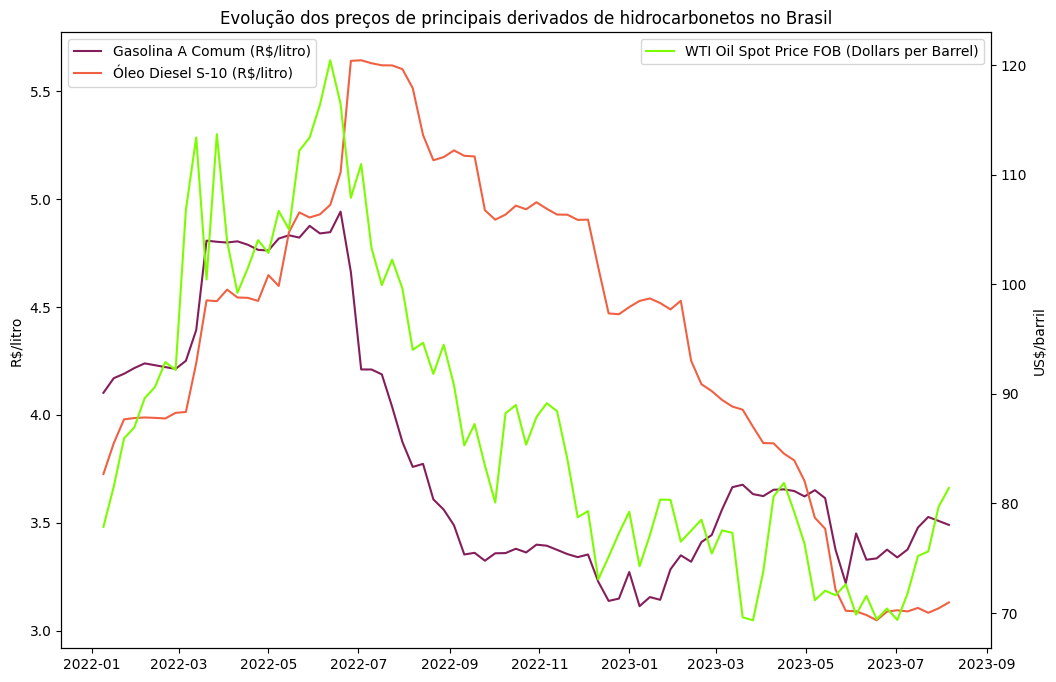

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    x="until", 
    y="price",
    hue="product",
    palette="rocket",
    ax = ax,
    data=plant_sel
)

ax2 = ax.twinx()

sns.lineplot(
    x="until", 
    y="wti_price",
    color="lawngreen",
    # legend=False,
    ax = ax2,
    data=oil_avg
)

ax.set_title("Evolução dos preços de principais derivados de hidrocarbonetos no Brasil")
ax.set_xlabel('')
ax.set_ylabel('R$/litro', size=10)
ax2.set_ylabel('US$/barril', size=10)

ax.legend(loc="upper left")
ax2.legend(loc="upper right", labels=["WTI Oil Spot Price FOB (Dollars per Barrel)"])

O preço da gasolina pare mais correlacionado com o do barril de WTI, vamos ver a correlação de Pearson para tirar a prova. 

In [36]:
np.corrcoef(plant_sel[(plant_sel["product"] == "Gasolina A Comum (R$/litro)")].price, oil_avg.wti_price)

array([[1.        , 0.83250776],
       [0.83250776, 1.        ]])

Correlação de 83%. Isso fornece segurança no uso do WTI Oil como variável de controle do preço da gasolina.

In [39]:
np.corrcoef(plant_sel[(plant_sel["product"] == "Óleo Diesel S-10 (R$/litro)")].price, oil_avg.wti_price)

array([[1.        , 0.61945855],
       [0.61945855, 1.        ]])

61% de correlação. Talvez precise pensar em outra variável de controle. 

O 3º governo Lula começou a ["abrasileirar" os preços dos combustíveis](https://youtu.be/kDxKYqQWAps) a partir de 16 de maio de 2023, com reduções de 12% nos preços da gasolina e do diesel. Vamos ver se isso é visualizado graficamente.  

Text(0.5, 1.0, 'Evolução dos preços de principais derivados de hidrocarbonetos no Brasil')

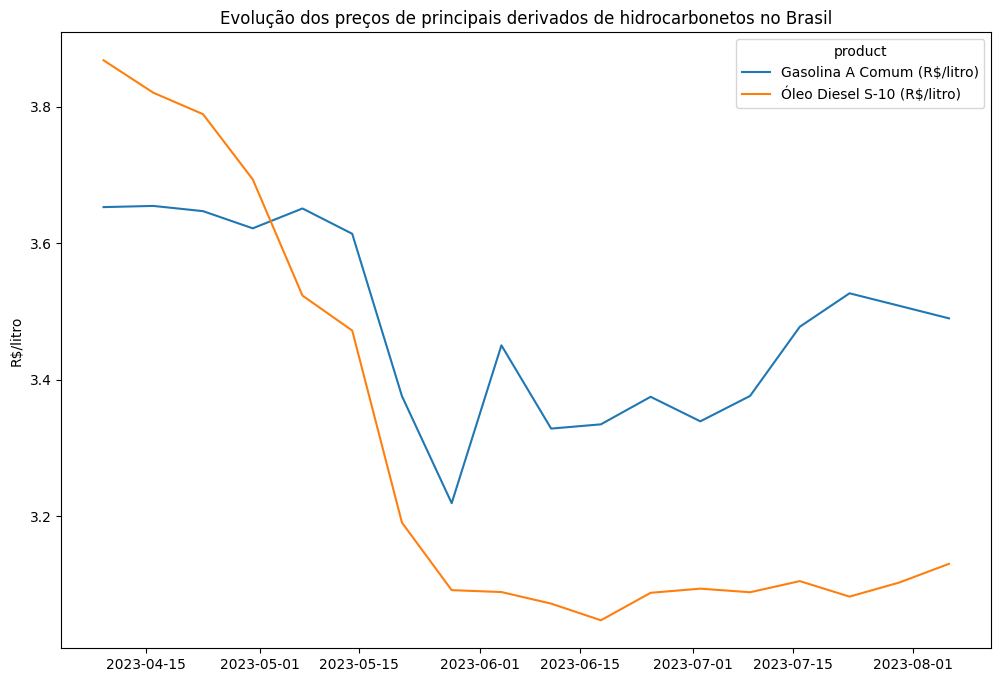

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(
    x="until", 
    y="price",
    hue="product",
    data=plant_sel[plant_sel.from_ >= "2023-04-01"]
)

plt.xlabel("", size=10)
plt.ylabel("R$/litro", size=10)

ax.set_title("Evolução dos preços de principais derivados de hidrocarbonetos no Brasil")

Dá para observar que houve essa redução. Mas persiste a pergunta: isso teve efeitos permanentes?

## Vamos aplicar a inferência causal sobre o preço de cada um dos derivados de hidrocarbonetos. 

Vamos começar a avaliação do preço da gasolina, dado o simbolismo, mas também pelo fato de possuir uma variável de controle mais sólida. 

É preciso construir uma base de periodicidade diária. 

In [66]:
cake_pan = pd.date_range("2022-01-01", str(date.today()), freq="D")
cake_pan = pd.DataFrame(cake_pan, columns=["day"])

Junte as demais séries temporais nessa base. 

In [67]:
gasoline = plant_sel[(plant_sel["product"] == "Gasolina A Comum (R$/litro)")].copy()

gasoline = cake_pan.merge(oil, how="left", on="day").\
                    merge(gasoline, how="cross")

gasoline = gasoline[(gasoline.day.between(gasoline.from_, gasoline.until))].\
            rename(columns = {"price": "gas_price"}).\
            drop(columns=["product", "until", "from_"])

,day,wti_price,gas_price
166,2022-01-03,75.99,4.10261
249,2022-01-04,77.00,4.10261
332,2022-01-05,77.83,4.10261
415,2022-01-06,79.47,4.10261
498,2022-01-07,79.00,4.10261
...,...,...,...
48056,2023-08-02,79.50,3.49014
48139,2023-08-03,81.56,3.49014
48222,2023-08-04,82.76,3.49014
48305,2023-08-05,NaN,3.49014


O procedimento abaixo é realizado ao visar a remoção do `N/A` sem remover registros do dataframe. A cotação do fim de semana e feriados segue aquilo que foi registrado na última data, ou seja, a cotação de sábado e domingo é aquilo que foi registrado na sexta-feira. 

In [13]:
gasoline["wti_price"] = np.where(gasoline["wti_price"].isna(), gasoline["wti_price"].shift(periods=1), gasoline["wti_price"])
gasoline["wti_price"] = np.where(gasoline["wti_price"].isna(), gasoline["wti_price"].shift(periods=1), gasoline["wti_price"])
gasoline["wti_price"] = np.where(gasoline["wti_price"].isna(), gasoline["wti_price"].shift(periods=1), gasoline["wti_price"])

Transforme o campo `day` em index com periodicidade diária.

In [14]:
gasoline = gasoline[(gasoline.day >= "2023-01-01")][["day", "gas_price", "wti_price"]].set_index(["day"])

gasoline = gasoline.asfreq('d')

Especifique as janelas de análise: o antes e depois da intervenção (tratamento). 

In [56]:
pre_start = gasoline.index.min()
pre_start = str(pre_start.strftime("%Y-%m-%d"))

pre_period=[pre_start, "2023-05-15"]

pre_period

['2023-01-01', '2023-05-15']

In [59]:
post_end = gasoline.index.max()
post_end = str(post_end.strftime("%Y-%m-%d"))

post_period=["2023-05-16", post_end]

post_period

['2023-05-16', '2023-08-06']

A janela não é prefixada, conforme há mais dados, vai mudando o `post_period`. 

Rode o modelo

In [42]:
impact = CausalImpact(gasoline, 
                      pre_period, post_period, 
                      model_args={"prior_level_sd":None, # Configure isso como None, conforme a documentação
                                  "nseasons":7,
                                  "season_duration":1}
                      )

/home/chico_linux/.local/lib/python3.10/site-packages/statsmodels/base/optimizer.py:17: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score. The list of unsupported keyword arguments passed include: standardize, nseasons, model_args. After release 0.14, this will raise.
  warnings.warn(


In [44]:
print(impact.summary(output='report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 3.4. By contrast, in the absence of an
intervention, we would have expected an average response of 3.58.
The 95% interval of this counterfactual prediction is [3.52, 3.63].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -0.18 with a 95% interval of
[-0.23, -0.12]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 275.27.
By contrast, had the intervention not taken place, we would have expected
a sum of 289.65. The 95% interval of this prediction is [285.28, 293.91].


The above results are given in terms of absolute numbers. In relative
terms, the response variable sh

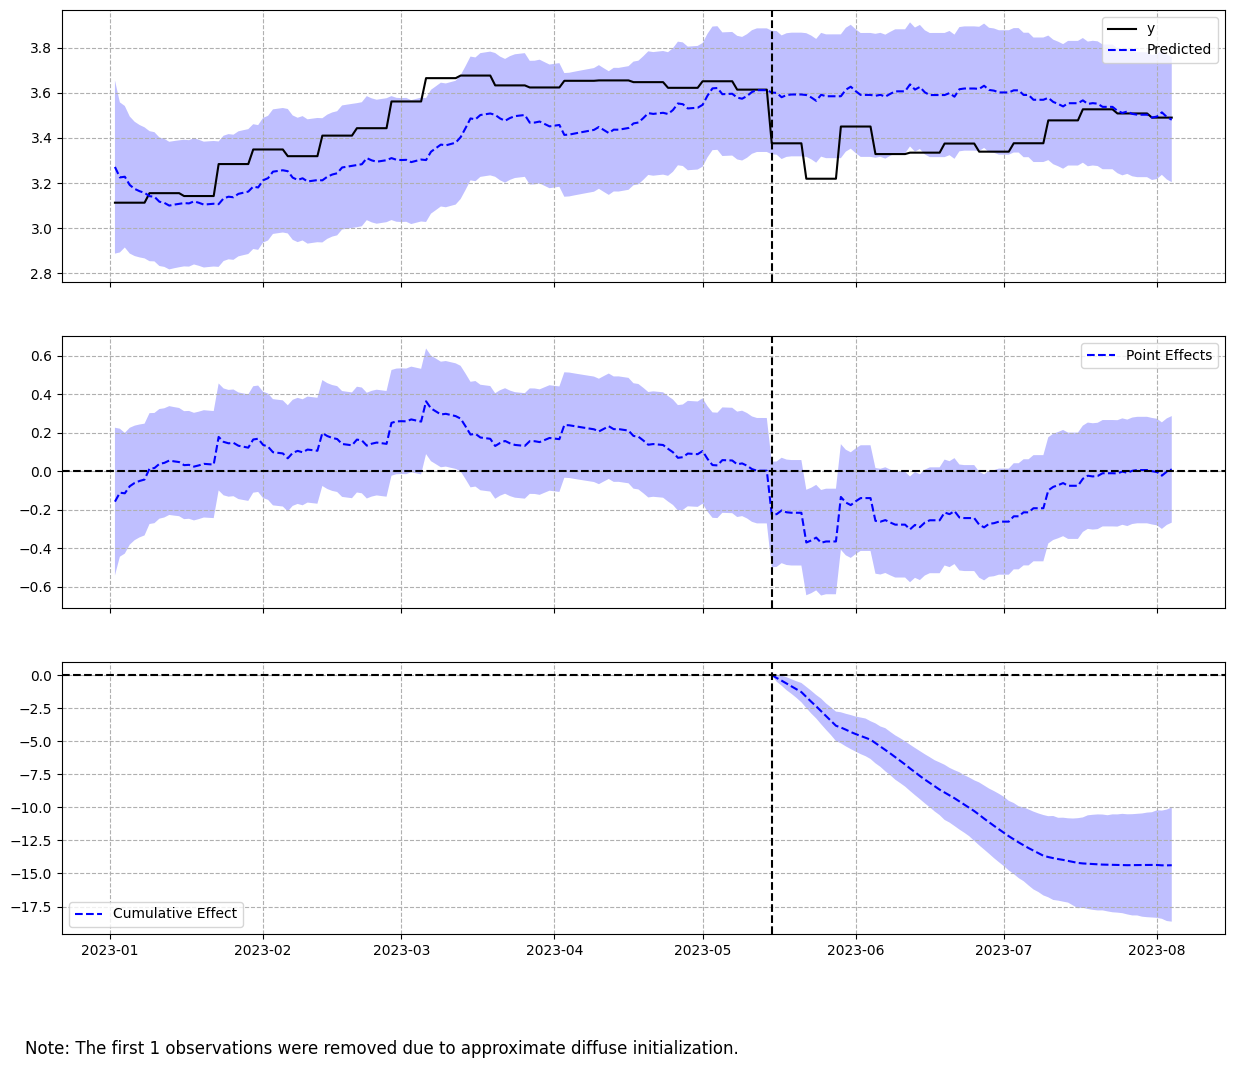

In [45]:
impact.plot()

In [43]:
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    3.4                275.27
Prediction (s.d.)         3.58 (0.03)        289.65 (2.2)
95% CI                    [3.52, 3.63]       [285.28, 293.91]

Absolute effect (s.d.)    -0.18 (0.03)       -14.38 (2.2)
95% CI                    [-0.23, -0.12]     [-18.64, -10.01]

Relative effect (s.d.)    -4.96% (0.76%)     -4.96% (0.76%)
95% CI                    [-6.44%, -3.45%]   [-6.44%, -3.45%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


O "abrasileiramento" dos preços da gasolina provocou uma queda de quase 5% no preço da gasolina. 

## Conclusão

O uso do `causalimpact` foi satisfatório, e mostrou que a nova política de preços da Petrobrás, a qual direciona o mercado brasileiro de gasolina, impactou com a redução do preço da gasolina, na ordem de __quase 5%__. O governo anunciou a redução em 12%, mas as posteriores oscilações de preço encolheram essa redução. 

É importante pontuar que a inferência causal aqui mostra a mudança estrutural derivada da nova política, isto é, houve uma mudança persistente que sobrevive ao furor do anúncio inicialmente. 

Como previsto, o uso do preço do barril de petróleo WTI é uma variável de controle eficaz, dada que a nova política vai abandonar o PPI (Política de Paridade de Importações), ou seja, a intervenção/tratamento não está muito correlacionada com o preço do barril de petróleo. 

Não se realizou a inferência do preço do diesel ao considerar a baixa correlação com o valor do barril de WTI, logo, é preciso procurar outra variável, no caso, a cotação de outro barril. 